In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib 
from datetime import datetime
from bokeh.charts import TimeSeries
from bokeh.io import output_file
from bokeh.io import *
import seaborn as sns
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

### Connecting to SQL server

In [4]:
config = dict(server='IMDWP2\Prod', 
              port=51433,               
              database= 'Corporate_DW',
              TRUSTED_CONNECTION='yes')


conn_str = ('SERVER={server},{port};'   +
            'DATABASE={database};'      +
            'TRUSTED_CONNECTION={TRUSTED_CONNECTION};')


conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 13 for SQL Server};' +
    conn_str.format(**config)
    )

cursor = conn.cursor()

### Extracting data & creating HR dataframe

In [10]:
cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_AARank') IS NOT NULL DROP TABLE #HRDS_Temp_AARank;")
cursor.commit()

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_AAPrior') IS NOT NULL DROP TABLE #HRDS_Temp_AAPrior;")
cursor.commit()

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_Promotions') IS NOT NULL DROP TABLE #HRDS_Temp_Promotions;")
cursor.commit()

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_EarlyHiring') IS NOT NULL DROP TABLE #HRDS_Temp_EarlyHiring;")
cursor.commit()

sql = "SELECT Person_Type_Id, Assignment_All_Id, JobCode_Id, Worker_Active_Indicator,\n"
sql +=" CAST(ROW_NUMBER() OVER(PARTITION BY Person_Type_Id ORDER BY Effective_Start_Date DESC, Effective_Sequence DESC) AS INT) AS RN \n"
sql += "INTO #HRDS_Temp_AARank \n"
sql += "FROM WFReportView.Worker_Info_All;"

cursor.execute(sql)
cursor.commit()

sql = "CREATE INDEX #HRDS_Temp_AARank_ix ON #HRDS_Temp_AARank (Person_Type_Id ASC);"
cursor.execute(sql)
cursor.commit()


sql = "SELECT A.Person_Type_Id, A.Assignment_All_Id, B.Assignment_All_Id AS Assignment_All_Id_Prior INTO #HRDS_Temp_AAPrior \n"
sql += "FROM #HRDS_Temp_AARank AS A LEFT JOIN #HRDS_Temp_AARank AS B ON A.Person_Type_Id = B.Person_Type_Id AND A.RN = B.RN - 1 \n"
sql +=  "WHERE A.Worker_Active_Indicator <> COALESCE(B.Worker_Active_Indicator, '') OR A.JobCode_Id <> COALESCE(B.JobCode_Id, -1);"

cursor.execute(sql)
cursor.commit()

sql = "CREATE INDEX #HRDS_Temp_AAPrior_ix ON #HRDS_Temp_AAPrior ( Person_Type_Id ASC, Assignment_All_Id ASC );"
cursor.execute(sql)
cursor.commit()

sql = "IF OBJECT_ID('tempdb..#HRDS_Temp_AARank') IS NOT NULL DROP TABLE #HRDS_Temp_AARank;"
cursor.execute(sql)
cursor.commit()

print("Step 1")

sql = "SELECT wi.Source_Worker_Id,"
sql +=" CAST(ROW_NUMBER() OVER(PARTITION BY wi.Person_Type_Id ORDER BY wi.Effective_Start_Date ASC, wi.Effective_Sequence ASC) AS INT) AS Job_Change_Sequence \n"
sql += ",wi.Assignment_All_Id, wi.Effective_Start_Date, wi.Effective_Sequence \n"
sql += ", jpa.Source_Action_Code, jpa.Source_Action_Reason_Code, jpa.Action_Short_Name, jpa.Action_Reason_Short_Name, jpa.Activity_Group_Name \n"
sql += ", jpa.Activity_Name, wi1.Worker_Active_Indicator AS Prior_Worker_Active_Indicator \n"
sql += ", wi.Worker_Active_Indicator, wi1.JobCode_Id AS Prior_JobCode_Id, wi.JobCode_Id INTO #HRDS_Temp_Promotions \n"
sql += " FROM WFReportView.Worker_Info_All AS wi INNER JOIN WFReportView.Job_Profile_All AS jpa \n"
sql += " ON wi.Assignment_All_Id = jpa.Assignment_All_Id INNER JOIN #HRDS_Temp_AAPrior AS ap \n"
sql += " ON wi.Person_Type_Id = ap.Person_Type_Id AND wi.Assignment_All_Id = ap.Assignment_All_Id \n"
sql += " LEFT JOIN WFReportView.Worker_Info_All AS wi1 ON wi.Person_Type_Id = wi1.Person_Type_Id \n"
sql += " AND wi1.Assignment_All_Id = ap.Assignment_All_Id_Prior WHERE wi.Effective_Start_Date >= '01/01/2012';"

cursor.execute(sql)

cursor.commit()

print("Step 2")

sql = "SELECT WIA.Source_Worker_Id, WIA.[Primary_Full_Name], PP.[Gender_Name] \n"
sql += ", PP.[Birth_Date], PP.[Home_Address_State_Name], PP.[Home_Address_State_Code], PP.[Home_Address_Postal_Code] \n"
sql += ", PP.[Home_Address_City], PP.[Primary_Ethnic_Group_Code], PP.[Primary_Ethnic_Group_Name], PP.[Marital_Status_Code] \n"
sql += ", PP.[Marital_Status_Name], PP.[Military_Status_Code], PP.[Military_Status_Name], PP.[Disabled_Indicator] \n"
sql += ", PP.[Disabled_Veteran_Indicator], PP.[Latest_Military_Discharge_Date], PP.[Disabled_Status_Code] \n"
sql += ", PP.[Disabled_Status_Name], PP.[Disabled_Disclosure_Date], WIA.Source_Department_Id, WIA.[Effective_Start_Date] \n"
sql += ", WIA.[Effective_End_Date], WIA.[JobTitle], WIA.[Department_Name], WIA.[EEO1_Code], WIA.[EEO1_Name] \n"
sql += ", WIA.[JobCode_All_Id], WIA.[JobCode_Id] \n"
sql += ", WIA.Worker_Classification_Name, WIA.Employee_Type_Name \n"
sql += ", WIA.FLSA_Classification_Name, WIA.Manager_Level_Name \n"
sql += ", WIA.Regular_Temporary_Name, WIA.FullTime_PartTime_Name, WIA.Labor_Union_Name \n"
sql += ", JIA.[Source_Salary_Grade], JIA.[Source_Salary_Plan], JIA.[EEO_Job_Group_Code] \n"
sql += ", JIA.[Job_Function_Code] INTO #HRDS_Temp_EarlyHiring \n"
sql += "  FROM WFReportView.Worker_Info_All AS WIA JOIN [WFReportView].[Job_Profile_All] AS JPA \n"
sql += "ON WIA.Assignment_All_Id = JPA.Assignment_All_Id AND JPA.Activity_Group_Name = 'Hire' \n"
sql += "AND JPA.Action_Name IN ( 'Hire', 'Rehire' ) AND WIA.Person_Type_Code = 'EMPL' \n"
sql += " AND WIA.Person_Sub_Type_Code = 'US' AND WIA.Worker_Active_Indicator = 'Y' \n"
sql += " AND WIA.effective_start_date >= '01/01/2012' AND WIA.Effective_Start_Date <> '10/01/2016' \n"
sql += " JOIN [WFReportView].[Department_Reporting_Level] AS DRL ON WIA.Department_Id = DRL.[Subordinate_Department_Id] \n"
sql +=  " AND DRL.Report_To_Source_Department_Id = '41000' JOIN WFReportView.Personal_Profile AS PP \n"
sql +=  " ON PP.Person_Id = WIA.Person_Id JOIN WFReportView.JobCode_Info_All AS JIA ON WIA.JobCode_All_Id = JIA.JobCode_All_Id;"

cursor.execute(sql)
cursor.commit()

print("Step 3")

sql = "SELECT 'Hire_Data' as Tabname, * FROM \n"
sql += " ( SELECT ea.*, PRO.Effective_Start_Date AS Chg_Effective_Start_Date \n"
sql += " , PRO.Effective_Sequence AS Chg_Effective_Sequence, PRO.Source_Action_Code AS Chg_Source_Action_Code \n"
sql += " , PRO.Source_Action_Reason_Code AS Chg_Source_Action_Reason_Code, PRO.Action_Short_Name AS Chg_Action_Short_Name \n"
sql += " , PRO.Action_Reason_Short_Name AS Chg_Action_Reason_Short_Name, PRO.Activity_Group_Name AS Chg_Activity_Group_Name \n"
sql += " , PRO.Activity_Name AS Chg_Activity_Name, PRO.Prior_Worker_Active_Indicator AS Chg_Prior_Worker_Active_Indicator \n"
sql += " , PRO.Worker_Active_Indicator AS Chg_Worker_Active_Indicator, PRO.Prior_JobCode_Id AS Chg_Prior_JobCode_Id \n"
sql += " , PRO.JobCode_Id AS Chg_JobCode_Id \n"
sql += " , wia.JobTitle AS Chg_JobTitle, wia.Source_Department_Id AS Chg_Source_Department_Id \n"
sql += " , WIA.[EEO1_Code] AS Chg_EEO1_Code, WIA.[EEO1_Name] AS Chg_EEO1_Name \n"
sql += " , JIA.[EEO_Job_Group_Code] AS Chg_EEO_JobGroup_Code, JIA.[Job_Function_Code] AS Chg_Job_Function_Code \n"
sql += " , CAST(ROW_NUMBER() OVER(PARTITION BY EA.Source_Worker_Id \n"
sql += " , EA.Effective_Start_Date ORDER BY PRO.Job_Change_Sequence) AS INT) AS Rnk \n"
sql += " FROM #HRDS_Temp_EarlyHiring AS EA \n"
sql += " LEFT JOIN #HRDS_Temp_Promotions AS PRO ON EA.Source_Worker_Id = PRO.Source_Worker_Id \n"
sql += " AND ea.effective_Start_Date < PRO.Effective_Start_Date \n"
sql += " LEFT JOIN WFReportView.Worker_Info_All wia \n"
sql += " ON PRO.Assignment_All_Id = wia.Assignment_All_Id \n"
sql += " LEFT JOIN WFReportView.JobCode_Info_All AS JIA \n"
sql += "      ON WIA.JobCode_All_Id = JIA.JobCode_All_Id) AS I \n"
sql += " WHERE Rnk = 1;"
cursor.execute(sql)

# extracting column labels
columns = [column[0] for column in cursor.description] 

# extracting the rows
rows = cursor.fetchall()
data=[]
for i in range(len(rows)):
    row=tuple(rows[i])
    data.append(row)

# creating a dataframe
HR = pd.DataFrame(data,columns=columns)
HR.to_csv('HR.csv')
        
        
        
print("Step 4")

for entry in cursor:
   print(entry)

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_AARank') IS NOT NULL DROP TABLE #HRDS_Temp_AARank;")
cursor.commit()

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_AAPrior') IS NOT NULL DROP TABLE #HRDS_Temp_AAPrior;")
cursor.commit()

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_Promotions') IS NOT NULL DROP TABLE #HRDS_Temp_Promotions;")
cursor.commit()

cursor.execute("IF OBJECT_ID('tempdb..#HRDS_Temp_EarlyHiring') IS NOT NULL DROP TABLE #HRDS_Temp_EarlyHiring;")
cursor.commit()

print("Step 5")


cursor.close()

Step 1
Step 2
Step 3
Step 4
Step 5


### Loading data from csv or can be loaded from the sql server directly

In [11]:
df1=pd.read_csv("HR.csv") 
df2 = pd.read_csv("HR.csv", parse_dates=[4,17, 20, 22,23,34], index_col='Effective_Start_Date')

C:\Chrisdata\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# Diplay the entire columns 
pd.set_option('display.max_columns', None)

In [13]:
del df1['Unnamed: 0']

In [14]:
parse_dates=[4,17, 20, 22,23,41]
df1.iloc[:,parse_dates] = df1.iloc[:,parse_dates].apply(pd.to_datetime, errors='coerce')

In [15]:
df1.iloc[:,parse_dates].dtypes
# df1.columns

Birth_Date                        datetime64[ns]
Latest_Military_Discharge_Date    datetime64[ns]
Disabled_Disclosure_Date          datetime64[ns]
Effective_Start_Date              datetime64[ns]
Effective_End_Date                datetime64[ns]
Chg_Effective_Start_Date          datetime64[ns]
dtype: object

### Feature Engineering

In [16]:
df1['Age'] = datetime.now().year - df1['Birth_Date'].dt.year

df1['Chg_Effective_Start_Date'].fillna(datetime.today(), inplace=True)

df1['Service_Period'] = (df1['Chg_Effective_Start_Date'] - df1['Effective_Start_Date']).apply(lambda s: s.days)

df1['Job_Family_Level'] = df1['EEO_Job_Group_Code'].str[1:]
df1['EEO_Job_Group_Code'] = df1['EEO_Job_Group_Code'].str[:1]

In [17]:
df1.Effective_Start_Date = df1.Effective_Start_Date.dt.week
df1.Chg_Effective_Start_Date = df1.Chg_Effective_Start_Date.dt.week

In [19]:
df_departmnt=pd.read_csv("DepartmentNames.csv")

df_departmnt =df_departmnt[['Source_Department_Id','Level4_Department_Name']]

df_final = pd.merge(df_departmnt, df1, on='Source_Department_Id', how='right')

In [27]:
df_JT_LOS=pd.read_csv("JT_LOS_Increments.csv")

df_JT_LOS = df_JT_LOS.drop_duplicates(['JobCode_Id'], keep='last')[['JobCode_Id','JT_LOS_Increments']]

df_final = pd.merge(df_JT_LOS, df_final, on='JobCode_Id', how='right')


In [26]:
#df_JT_LOS=pd.read_csv("JT_LOS_Increments.csv")
#df_JT_LOS.head()

In [30]:
df_final.JT_LOS_Increments.replace(to_replace=-1, value=0, inplace=True)

In [31]:
df_final.dropna(subset=['JT_LOS_Increments'], inplace=True)

In [33]:
df5= df_final.groupby(by=['JT_LOS_Increments', 'Level4_Department_Name','Regular_Temporary_Name'], as_index=False).mean()
df6= df_final.groupby(by=['JT_LOS_Increments', 'Level4_Department_Name','Regular_Temporary_Name'], as_index=False).count()

In [34]:
df5.Source_Worker_Id = df6.Source_Worker_Id

In [35]:
col = ['Source_Worker_Id','JT_LOS_Increments','Regular_Temporary_Name', 'Level4_Department_Name','Age','Service_Period','Chg_Effective_Start_Date','Effective_Start_Date' ]

df = df5[col]

In [37]:
#df.head()

In [38]:
df.to_csv(path_or_buf="HR_data.csv", sep=',')

## Regression Model on the count of employees with different level of experience

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'keras'

### Log transforming the Worker_Id

In [53]:
df.Source_Worker_Id= np.log(df.Source_Worker_Id)

df.Level4_Department_Name = df.Level4_Department_Name.astype('category')
df.Regular_Temporary_Name = df.Regular_Temporary_Name.astype('category')

C:\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [17]:
Y = df.Source_Worker_Id.values
X = df.drop('Source_Worker_Id', axis=1).values


In [18]:
Y.shape

(152,)

In [19]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(7, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [54]:
seed = 7
np.random.seed(seed)
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)


In [129]:
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: 2.97 (1.04) MSE


In [105]:

le.fit(df5.Level4_Department_Name)

le.classes_

for i,j in enumerate(le.classes_):
    print (i,'--', j)

0 -- Admin Svcs & Human Resources
1 -- Distb, Cust Ops & DE Carolina
2 -- Energy Solutions&MW/FL Regions
3 -- Finance & Technology
4 -- Gas Operations
5 -- Generation & Transmission
6 -- Legal, E&C & External Affairs
7 -- Office of CEO Admin Support


In [104]:
le.fit(df5.Regular_Temporary_Name)

le.classes_

for i,j in enumerate(le.classes_):
    print (i,'-----', j)

0 ----- Probation
1 ----- Regular
2 ----- Temporary


In [101]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)



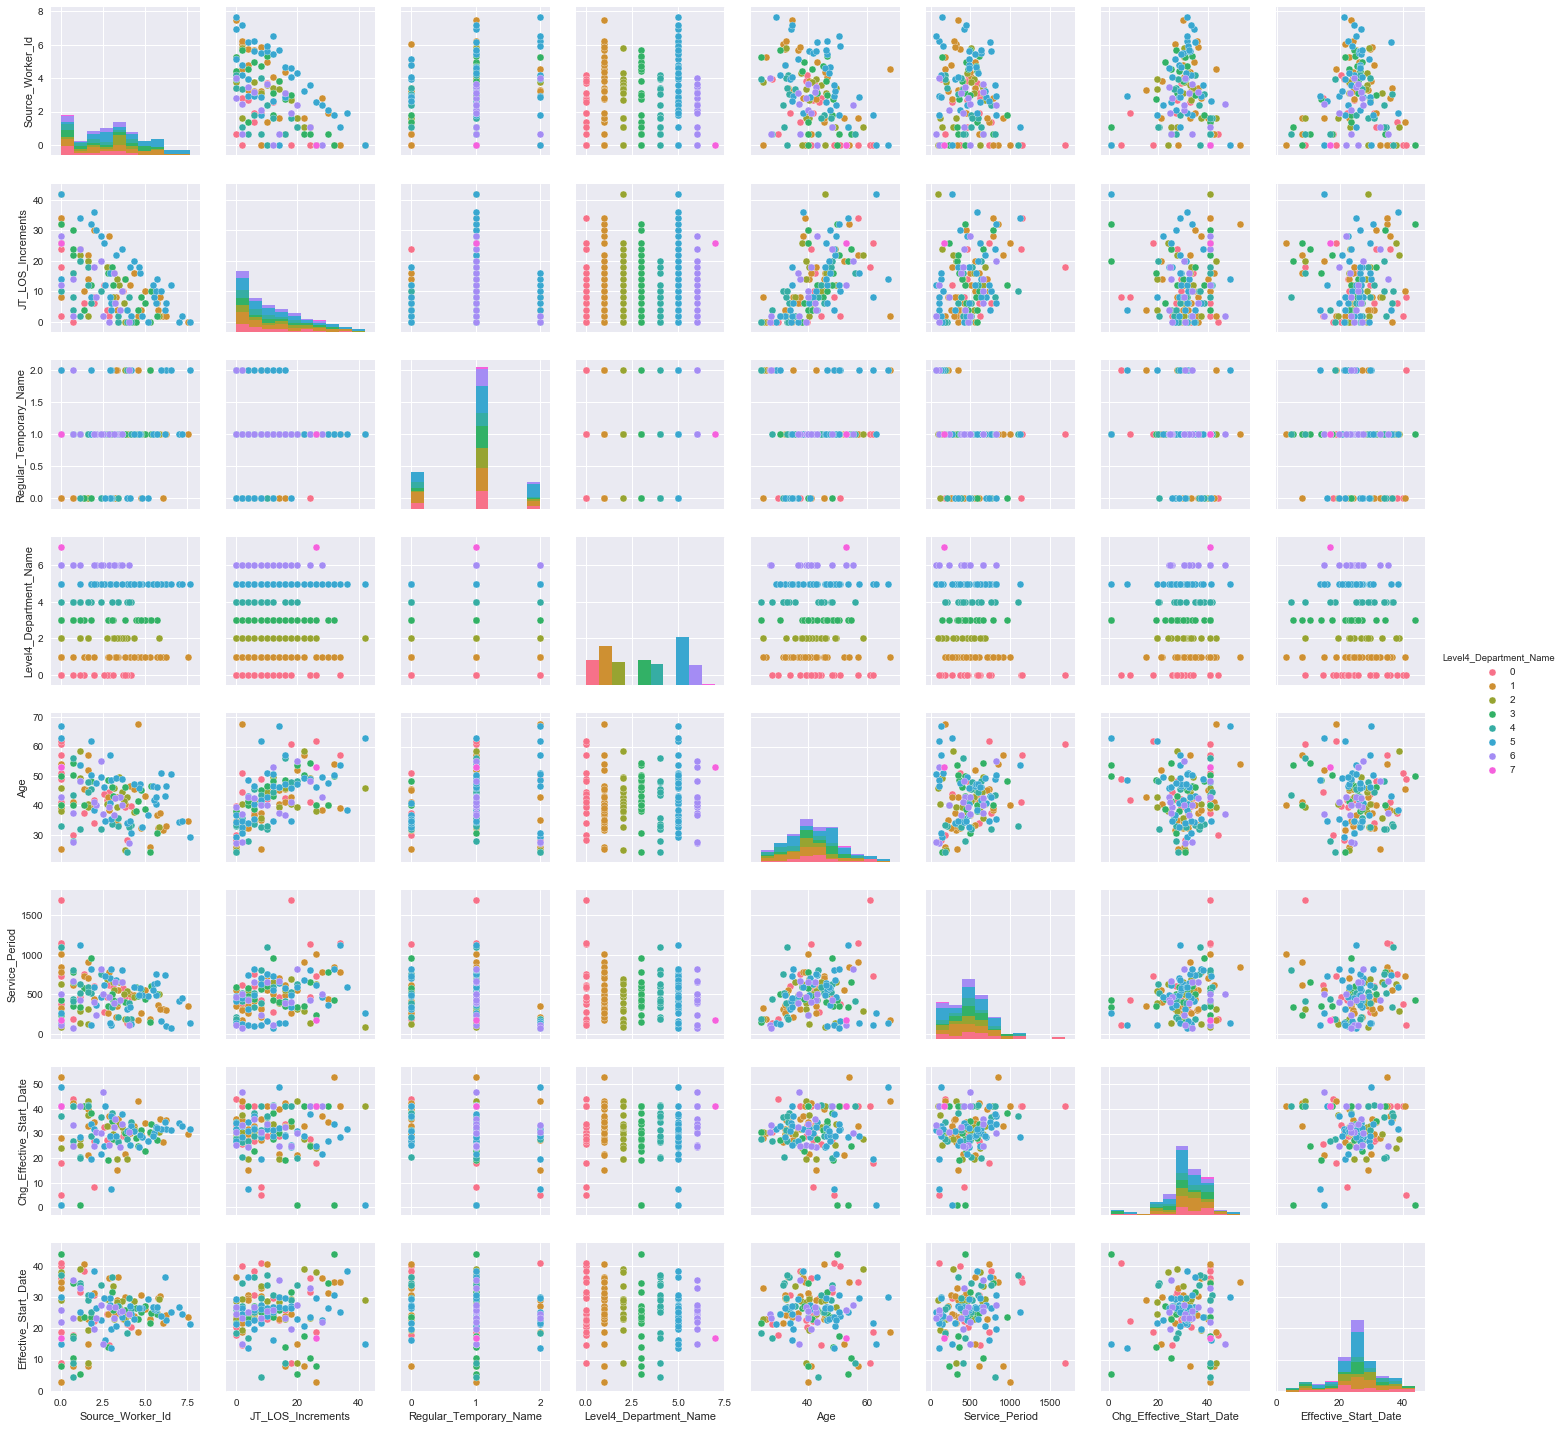

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline
plt.figure()

sns.pairplot(data=df, hue = 'Level4_Department_Name')

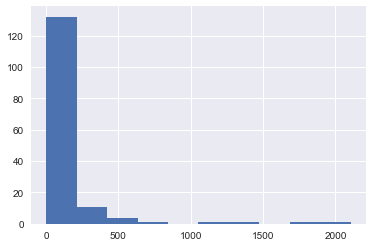

In [97]:
df6.Source_Worker_Id.hist()

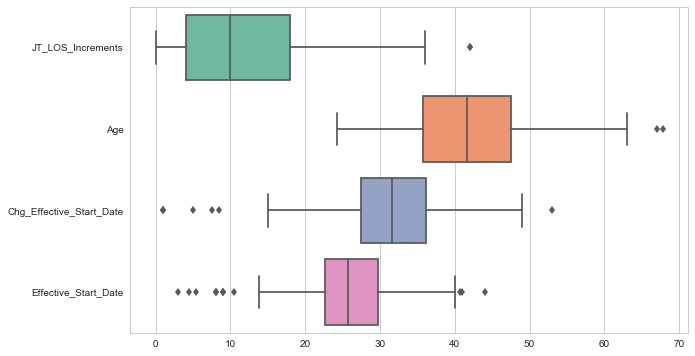

In [94]:
plt.figure(figsize = (10, 6))
sns.set_style("whitegrid")
ax = sns.boxplot(data=df[['JT_LOS_Increments','Age','Chg_Effective_Start_Date','Effective_Start_Date' ]]
, orient="h", palette="Set2", saturation = .8, fliersize = 6.)

In [42]:
df.corr() > 0.3

,Source_Worker_Id,JT_LOS_Increments,Regular_Temporary_Name,Level4_Department_Name,Age,Service_Period,Chg_Effective_Start_Date,Effective_Start_Date
Source_Worker_Id,True,False,False,False,False,False,False,False
JT_LOS_Increments,False,True,False,False,True,True,False,False
Regular_Temporary_Name,False,False,True,False,False,False,False,False
Level4_Department_Name,False,False,False,True,False,False,False,False
Age,False,True,False,False,True,False,False,False
Service_Period,False,True,False,False,False,True,False,False
Chg_Effective_Start_Date,False,False,False,False,False,False,True,False
Effective_Start_Date,False,False,False,False,False,False,False,True


In [116]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor,LassoCV, ElasticNetCV,RidgeCV
import numpy as np
import pylab as pl

C:\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [121]:
alphas = np.logspace(-4, -.5,  6.9346206263)
lasso = LassoCV(alphas=alphas)
lasso.fit(X, Y)
LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)
# The estimator chose automatically its lambda:
lasso.alpha_ 

0.31622776601683794

In [126]:
elastic = ElasticNetCV()
elastic.fit(X, Y)
ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False,
             precompute='auto', max_iter=1000, tol=0.0001, cv=None, copy_X=True, verbose=0, n_jobs=1, 
             positive=False, random_state=None, selection='cyclic')
# The estimator chose automatically its lambda:
elastic.alpha_ 


102.62895597955772

In [127]:
from sklearn.linear_model import RidgeCV 
ridge = RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None,
        store_cv_values=False)
ridge.fit(X, Y)
ridge.alpha_

10.0

In [130]:
from sklearn.metrics import r2_score 
import pylab as pl

alphaRidge = 10.0
alphaLasso = 0.31622776601683794
alphaElastic = 102.62895597955772
for name,met in [ ('linear regression', LinearRegression()),
                 ('lasso', Lasso(fit_intercept=True, alpha=alphaLasso)),
                 ('ridge', Ridge(fit_intercept=True, alpha=alphaRidge)), 
                 ('elastic-net', ElasticNet(fit_intercept=True, alpha=alphaElastic)) ]: 
    met.fit(X,Y)
    # p = np.array([met.predict(xi) for xi in x])
    p = met.predict(X)
    e = p-y
    total_error = np.dot(e,e)
    rmse_train = np.sqrt(total_error/len(p))
    print (name, total_error, rmse_train)


linear regression 16310870.2241 394.134014242
lasso 16310873.6596 394.134055749
ridge 16310919.2703 394.134606814
elastic-net 16625433.5807 397.916401614


In [80]:
column_Names = df_final.columns.tolist()

### Dropping redundant columns

In [83]:
drop_List = ['Tabname',
 'Birth_Date',
 'Source_Worker_Id',
 'Primary_Full_Name',
 'Home_Address_State_Code',
 'Primary_Ethnic_Group_Code',
 'Marital_Status_Code',
 'Military_Status_Code',
 'Disabled_Status_Code',
 'Effective_End_Date',
 'EEO1_Name',
 'Chg_EEO1_Code',
 'Chg_Prior_JobCode_Id',
 'Latest_Military_Discharge_Date',
 'Disabled_Disclosure_Date',
 'Rnk']

In [84]:
df_final.drop(drop_List, axis=1,inplace=True)

### Change of activity is null for 4476 employees because they dont have change in empoyment status. Lets replace the null value with NoChange

In [85]:
change_Activity_Cat = ['Chg_Effective_Sequence',
 'Chg_Source_Action_Code',
 'Chg_Source_Action_Reason_Code',
 'Chg_Action_Short_Name',
 'Chg_Action_Reason_Short_Name',
 'Chg_Activity_Group_Name',
 'Chg_Activity_Name',
 'Chg_Prior_Worker_Active_Indicator',
 'Chg_Worker_Active_Indicator',
 'Chg_JobTitle',
 'Chg_EEO1_Name',
 'Chg_EEO_JobGroup_Code',
 'Chg_Job_Function_Code']

change_Activity_Int = ['Chg_JobCode_Id',                
 'Chg_Source_Department_Id']

Change effective day null replaced by today

In [103]:
# df_final[df_final.Chg_Source_Department_Id.isnull()]

In [86]:
df_final['Chg_Effective_Start_Date'].fillna(datetime.today(), inplace=True)

df_final['Chg_Effective_Sequence'].fillna(5 , inplace=True)

df_final['Chg_Source_Department_Id'] = pd.to_numeric(df_final.Chg_Source_Department_Id, errors='coerce')

In [87]:
for i in change_Activity_Cat :
    df_final[i].fillna("NoChange", inplace=True)
    
for i in change_Activity_Int :
    df_final[i].fillna(0, inplace=True)

### if Labor Union name is null - Non Union
### if Disabled_Status_Code is null - 'X' not indicated

In [88]:
df_final['Labor_Union_Name'].fillna("Non Union", inplace=True)
df_final['Disabled_Status_Name'].fillna("X", inplace=True)
df_final['Disabled_Veteran_Indicator'].fillna("X", inplace=True)
df_final['Disabled_Indicator'].fillna("X", inplace=True)
df_final['Manager_Level_Name'].fillna("X", inplace=True)
df_final['Military_Status_Name'].fillna("I do not wish to disclose", inplace=True)
df_final['Job_Function_Code'].fillna("X", inplace=True)

#### Trancating zip code to 5 digits, 18 missng and 2 with sate name for zip code

In [89]:
df_final.Home_Address_Postal_Code = df_final.Home_Address_Postal_Code.str[0:5]

df_final= df_final[df_final.Home_Address_Postal_Code != 'L1A 3']

df_final.Home_Address_Postal_Code[df_final.Home_Address_Postal_Code.str.len()<5] = np.nan


In [91]:
df_final.shape

(28730, 49)

In [268]:
null_row = df_final.isnull().sum(axis=1)

In [269]:
df_final[null_row>2].shape

(16, 48)

In [270]:
df_final.isnull().sum()[df_final.isnull().sum()>0]

Level4_Department_Name        3
Home_Address_State_Name      19
Home_Address_Postal_Code     18
Home_Address_City            18
Primary_Ethnic_Group_Name     3
EEO_Job_Group_Code            1
Job_Family_Level              1
dtype: int64

In [271]:
null_List = df_final.isnull().sum()[df_final.isnull().sum()>0].index.tolist()

In [272]:
df_final.dropna(subset=null_List, inplace=True)

In [273]:
df_final.isnull().sum()[df_final.isnull().sum()>0]

Series([], dtype: int64)

### Dropped only 28 (less than 0.2% of total data) NA rows

In [274]:
# number of NA rows dropped and percentage of total rows
16321 - df_final.shape[0], 100*df_final.shape[0]/16321

(29, 99.8223148091416)

## Classification Model Building on Chg_Worker_Active_Indicator - whether or not the empolyee is promoted, terminated or stayed in same position

In [275]:
# Run this cell twice

import numpy as np
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import warnings; warnings.simplefilter('ignore')

In [276]:
categorical_list = ['Level4_Department_Name',
'Gender_Name', 
'Home_Address_State_Name',
 'Home_Address_City',
 'Primary_Ethnic_Group_Name',
 'Marital_Status_Name',
 'Military_Status_Name',
 'Disabled_Indicator',
 'Disabled_Veteran_Indicator',
 'Disabled_Status_Name',
 'JobTitle',
 'Department_Name',
 'EEO1_Code',
 'Worker_Classification_Name',
 'Employee_Type_Name',
 'FLSA_Classification_Name',
 'Manager_Level_Name',
 'Regular_Temporary_Name',
 'FullTime_PartTime_Name',
 'Labor_Union_Name',
 'Source_Salary_Grade',
 'Source_Salary_Plan',
 'EEO_Job_Group_Code',
 'Job_Function_Code',
 'Chg_Effective_Sequence',
 'Chg_Source_Action_Code',
 'Chg_Source_Action_Reason_Code',
 'Chg_Action_Short_Name',
 'Chg_Action_Reason_Short_Name',
 'Chg_Activity_Group_Name',
 'Chg_Activity_Name',
 'Chg_Prior_Worker_Active_Indicator',
 'Chg_Worker_Active_Indicator',
 'Chg_JobTitle',
 'Chg_EEO1_Name',
 'Chg_EEO_JobGroup_Code',
 'Chg_Job_Function_Code',
 'Job_Family_Level']



In [277]:
for col in categorical_list:
    df_final[col] = df_final[col].astype('category')

In [278]:
df_trial = df_final.copy()

In [279]:
le = preprocessing.LabelEncoder()

for i in categorical_list :
    df_trial.loc[:,i] = le.fit_transform(df_trial.loc[:,i])

In [116]:
# df_trial.dtypes

In [50]:

# le.fit(df_final['Home_Address_State_Name'])

# list(le.classes_)

In [173]:
Y = df_trial.Chg_Worker_Active_Indicator.values

X = df_trial.drop('Chg_Worker_Active_Indicator', axis=1).values


In [280]:
df_trial.head()

,Source_Department_Id,Level4_Department_Name,Gender_Name,Home_Address_State_Name,Home_Address_Postal_Code,Home_Address_City,Primary_Ethnic_Group_Name,Marital_Status_Name,Military_Status_Name,Disabled_Indicator,Disabled_Veteran_Indicator,Disabled_Status_Name,Effective_Start_Date,JobTitle,Department_Name,EEO1_Code,JobCode_All_Id,JobCode_Id,Worker_Classification_Name,Employee_Type_Name,FLSA_Classification_Name,Manager_Level_Name,Regular_Temporary_Name,FullTime_PartTime_Name,Labor_Union_Name,Source_Salary_Grade,Source_Salary_Plan,EEO_Job_Group_Code,Job_Function_Code,Chg_Effective_Start_Date,Chg_Effective_Sequence,Chg_Source_Action_Code,Chg_Source_Action_Reason_Code,Chg_Action_Short_Name,Chg_Action_Reason_Short_Name,Chg_Activity_Group_Name,Chg_Activity_Name,Chg_Prior_Worker_Active_Indicator,Chg_Worker_Active_Indicator,Chg_JobCode_Id,Chg_JobTitle,Chg_Source_Department_Id,Chg_EEO1_Name,Chg_EEO_JobGroup_Code,Chg_Job_Function_Code,Age,Service_Period,Job_Family_Level
0,10865,0,0,31,28202,318,6,3,3,0,0,1,28,690,2901,8,176352,23156,2,2,2,3,1,0,9,190,4,9,20,35,0,8,41,8,37,4,7,2,2,9552.0,469,10865.0,3,32,18,32,52,2
1,10865,0,0,39,29707,848,6,3,3,1,1,3,34,690,2901,8,176352,23156,2,2,2,3,1,0,9,190,4,9,20,35,0,8,41,8,37,4,7,2,2,9552.0,469,10865.0,3,32,18,38,10,2
2,10865,0,0,31,28226,318,6,4,3,0,1,1,10,988,2901,2,179012,6699,2,1,4,2,1,0,9,182,5,3,0,39,1,8,41,8,37,4,7,2,2,2716.0,248,24960.0,0,17,0,63,574,2
3,10865,0,0,31,28269,318,6,4,4,1,1,3,25,988,2899,2,179012,6699,2,1,4,2,1,0,9,182,5,3,0,41,5,5,35,5,31,3,6,1,1,0.0,548,0.0,6,33,28,36,112,2
4,10925,5,1,31,28078,833,6,4,3,0,0,1,2,302,1772,0,21682,3968,2,2,5,2,1,0,9,185,4,1,13,22,0,8,41,8,37,4,7,2,2,22163.0,229,18495.0,8,3,13,29,509,1


In [281]:
from sklearn.cross_validation import StratifiedKFold , cross_val_score

num_cv_iterations = 10
num_instances = len(Y)
cv_object = StratifiedKFold(Y,n_folds=10)

### DecisionTreeClassifier Machine model¶
Creating a DecisionTreeClassifier model using RandomizedSearch...

In [127]:
from sklearn.tree import DecisionTreeClassifier

# build a classifier
Decision_clf = DecisionTreeClassifier()

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} +/- std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(Decision_clf, param_distributions=param_dist,n_iter=n_iter_search, cv = cv_object)

start = time()
random_search.fit(X, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 8.71 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.982 +/- std: 0.025)
Parameters: {'splitter': 'best', 'max_features': 4, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.901 +/- std: 0.095)
Parameters: {'splitter': 'best', 'max_features': 3, 'max_depth': 4, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.900 +/- std: 0.055)
Parameters: {'splitter': 'best', 'max_features': 3, 'max_depth': 4, 'criterion': 'gini'}



### Best Model with 99% accuracy

In [132]:
clf =DecisionTreeClassifier(criterion = 'gini', max_features= 4, max_depth=5, splitter = 'best')
acc = cross_val_score(Decision_clf,X,y=Y,cv=cv_object)
# tree.export_graphviz(clf,out_file='mytree.dot')
print("time it took - %.2f seconds ."  % (time() - start))
print ("Average accuracy = ", acc.mean()*100, "+/-", acc.std()/2*100)

time it took - 73.74 seconds .
Average accuracy =  99.9938612646 +/- 0.00920810313076


In [144]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
# from io import BytesIO as StringIO
from IPython.display import Image
from sklearn import tree
import pydotplus
import pydot
import graphviz
import os


In [157]:
!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org GraphViz

In [163]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.png", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = [ "-Tpng", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [164]:
# Unable to visualize due to Viz install issues
visualize_tree(clf, X.columns)
# name

In [273]:
out.getvalue()

b''

## RandomForest Model

- the model rank and results with parameters are displayed for comparison with other classifiation model.

In [165]:
# build a classifier
RandomF_clf = RandomForestClassifier(n_estimators=20)

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} +/- std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "min_samples_split": [2, 6, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(RandomF_clf, param_distributions=param_dist,n_iter=n_iter_search, cv = cv_object)


<B>GridSearchCV and RandomizedSearchCV</B> on appropriate parameters. As shown below RandomizedSearchCV takes very low time and results are comaprable to GridSearchCV

In [166]:
start = time()
random_search.fit(X, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 38.50 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 1.000 +/- std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 1.000 +/- std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 1.000 +/- std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 6}



In [167]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 6, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(RandomF_clf, param_grid=param_grid, cv = cv_object)
start = time()
grid_search.fit(X, Y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 414.70 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 1.000 +/- std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 1.000 +/- std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 1.000 +/- std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}



### Average accuracy over 10 folds - using the best parameter chosen by the grid search CV

In [168]:
start = time()
RandomF_clf =RandomForestClassifier(max_depth= None, bootstrap= True, min_samples_leaf= 1, min_samples_split= 2,
                            criterion = 'gini', max_features= None)
acc = cross_val_score(RandomF_clf,X,y=Y,cv=cv_object)
print("time it took - %.2f seconds ."  % (time() - start))
print ("Average accuracy = ", acc.mean()*100, "+/-", acc.std()/2*100)

time it took - 3.71 seconds .
Average accuracy =  99.9815837937 +/- 0.0140656098679


In [174]:
for train, test in cv_object:
    # train the decision tree algorithm
    RandomF_clf.fit(X[train],Y[train])
    yhat = RandomF_clf.predict(X[test])

### Important features

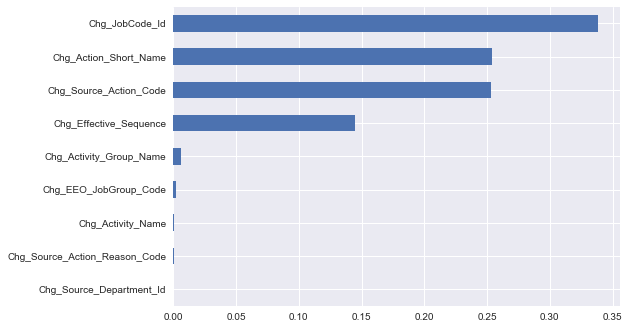

In [185]:
imp =RandomF_clf.feature_importances_
names = names = df_trial.drop('Chg_Worker_Active_Indicator', axis=1).columns
imp_features = pd.Series(imp,index=names)
imp_features[imp_features > 0].sort_values().plot(kind='barh')
plt.show()

In [159]:
random_search.predict(X[100])

array([2], dtype=int64)

### Model without the change of activity attributes

In [282]:
change_Activity_list = ['Chg_Effective_Sequence',
 'Chg_Source_Action_Code',
 'Chg_Source_Action_Reason_Code',
 'Chg_Action_Short_Name',
 'Chg_Action_Reason_Short_Name',
 'Chg_Activity_Group_Name',
 'Chg_Activity_Name',
 'Chg_Prior_Worker_Active_Indicator',
 'Chg_Worker_Active_Indicator',
 'Chg_JobTitle',
 'Chg_EEO1_Name',
 'Chg_EEO_JobGroup_Code',
 'Chg_Job_Function_Code',
 'Chg_JobCode_Id',  
 'Chg_Effective_Start_Date',
 'Chg_Source_Department_Id']


In [319]:
Y = df_trial.Chg_Worker_Active_Indicator.values

X = df_trial.drop(change_Activity_list, axis=1).values   


## RandomForest Model with out change of activity features

- the model rank and results with parameters are displayed for comparison with other classifiation model.

In [284]:
# build a classifier
RandomF_clf = RandomForestClassifier(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "min_samples_split": [2, 6, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(RandomF_clf, param_distributions=param_dist,n_iter=n_iter_search, cv = cv_object)


<B>GridSearchCV and RandomizedSearchCV</B> on appropriate parameters. As shown below RandomizedSearchCV takes very low time and results are comaprable to GridSearchCV

In [285]:
start = time()
random_search.fit(X, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 79.17 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.818 +/- std: 0.058)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.816 +/- std: 0.059)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.809 +/- std: 0.055)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 2}



In [286]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 6, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(RandomF_clf, param_grid=param_grid, cv = cv_object)
start = time()
grid_search.fit(X, Y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 756.86 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.825 +/- std: 0.054)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.821 +/- std: 0.057)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.821 +/- std: 0.060)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 6}



### Average accuracy over 10 folds is 82.2% - using the best parameter chosen by the grid search CV

In [294]:
start = time()
RandomF_clf =RandomForestClassifier(max_depth= None, bootstrap= False, min_samples_leaf= 10, min_samples_split= 10,
                            criterion = 'entropy', max_features= 10)
acc = cross_val_score(RandomF_clf,X,y=Y,cv=cv_object)
print("time it took - %.2f seconds ."  % (time() - start))
print ("Average accuracy = ", acc.mean()*100, "+/-", acc.std()/2*100)

time it took - 5.89 seconds .
Average accuracy =  82.1816222596 +/- 2.76166609588


In [295]:
for train, test in cv_object:
    # train the decision tree algorithm
    RandomF_clf.fit(X[train],Y[train])
    yhat = RandomF_clf.predict(X[test])

### Important features

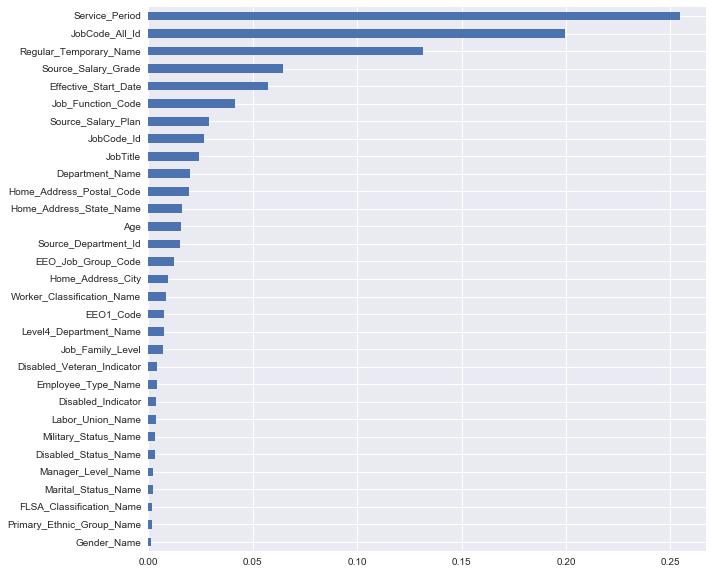

In [296]:
imp =RandomF_clf.feature_importances_
names = names = df_trial.drop(change_Activity_list, axis=1).columns
imp_features = pd.Series(imp,index=names)
imp_features[imp_features > 0.001].sort_values().plot(kind='barh', figsize=(10, 10))
plt.show()

Clearly the three most important predictors are Service period, Jobcode ID, and Regular_Temporary_Name. And the features that is almost insignificant are Gender, Ethnicity, Marital Status and Disability and Mangment level.

In [316]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt



Wall time: 1e+03 µs


### KNN has only 70% accuracy

In [360]:
Y = df_trial.Chg_Worker_Active_Indicator.values

X = df_trial.drop(change_Activity_list, axis=1).values



In [347]:
num_cv_iterations = 10
num_instances = len(Y)
cv_object = StratifiedKFold(Y, n_folds=10)

scl = StandardScaler()
X = scl.fit_transform(X)

In [352]:

from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 3
# num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [355]:
%%time

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv_object.split(X,Y):
    clf.fit(X[train],Y[train])
    yhat = clf.predict(X[test])
    ytest = Y[test]
    total_accuracy = mt.accuracy_score(ytest, yhat)
    print ('KNN accuracy', total_accuracy)

KNN accuracy 0.739797483891
KNN accuracy 0.739490641301
KNN accuracy 0.737649585763
Wall time: 4.24 s


In [336]:
for train_indices, test_indices in cv_object.split(X,Y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices] 

scl_obj = StandardScaler()
scl_obj.fit()
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)


(1629,)

### SVM - dont run it it takes alot of time.

In [359]:
from sklearn import svm, grid_search

Y = df_trial.Chg_Worker_Active_Indicator.values

X = df_trial.drop(change_Activity_list, axis=1).values

scl = StandardScaler()
X_scaled = scl.fit_transform(X)

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernel = ['linear', 'rbf']
    param_grid = {'kernel':kernel,'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)    
    return grid_search.best_params_

In [ ]:
%%time
svc_param_selection(X,Y,10)

## RandomForest Model with out change of activity features

- the model rank and results with parameters are displayed for comparison with other classifiation model.

In [ ]:
Y = df_trial.Chg_Worker_Active_Indicator.values

X = df_trial.drop(change_Activity_list, axis=1).values   

In [ ]:
df1.Chg_Activity_Name.isnull().sum()

In [297]:
print(df1.Age.describe(), '\n')
print('Median - ', df1.Age.describe().median())

count    16321.000000
mean        37.311378
std         12.190853
min         18.000000
25%         28.000000
50%         34.000000
75%         45.000000
max         81.000000
Name: Age, dtype: float64 

Median -  35.65568898964524


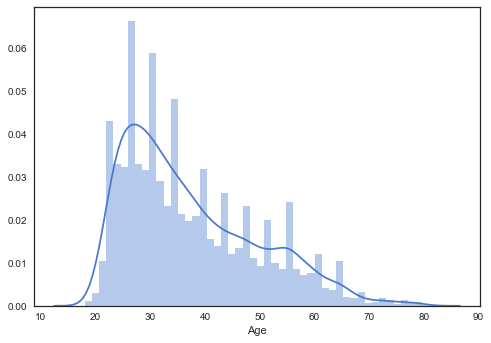

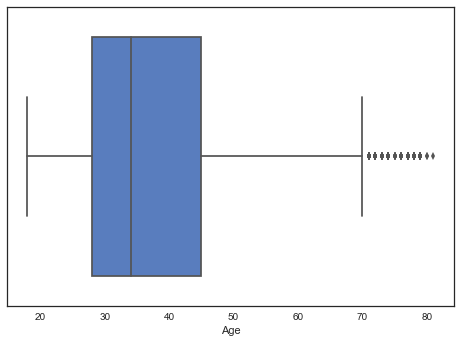

In [35]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(df1.Age)
plt.show()
sns.boxplot(df1.Age)
plt.show()

###  Two-sided test for Empolyee Age
<B> Null hypothesis </B> the expected Age (mean) of a Duke Employee a is equal to the Utility Industry population mean (46.4)

<p>[Avergae age of employee in Utility Industry](https://www.bls.gov/cps/cpsaat18b.htm) is 46.4</p>

A one sample t-test allows us to test whether a sample median differs significantly from a hypothesized value

In [10]:
from scipy import stats

Age_Hypothesis = stats.ttest_1samp(df1.Age,46.4)

In [11]:
print (' t-Statistics {0:.2f}\n the p-value of the test - {1:.2f} '.format(Age_Hypothesis[0],Age_Hypothesis[1]))

 t-Statistics -95.24
 the p-value of the test - 0.00 


<B>With 95% confidence we have enough evidence (Pval < 0.05) to reject Null Hypothesis that expected Age (mean) of a Duke Employees is equal to the Utility Industry population mean (46.4).</B>

#### Chi-Square test of Independence is used to determine if there is a significant relationship between two nominal (categorical) variables. 
<p>In this case between Chg_Worker_Active_Indicator and Regular_Temporary_Name</p>

<b>Null hypothesis</b>: Assumes that there is no association between the two variables.

<b>Alternative hypothesis</b>: Assumes that there is an association between the two variables.

In [15]:
df1.Chg_Worker_Active_Indicator.fillna("NONE", inplace=True)

In [16]:
crosstab = pd.crosstab(df1.Regular_Temporary_Name,df1.Chg_Worker_Active_Indicator , margins=False)

result = stats.chi2_contingency(crosstab)


In [17]:
print (' chi2 {0:.2f}\n the p-value of the test - {1:.2f}\n Degrees of freedom {2:.2f}  '.format(result[0],result[1],result[2]))

 chi2 8187.19
 the p-value of the test - 0.00
 Degrees of freedom 4.00  


<B>With 95% confidence we have enough evidence (Pval < 0.05) to reject Null Hypothesis that there is no association between the two variables.</B>

In [12]:
df1['Chg_Effective_Start_Date'].fillna(datetime.today(), inplace=True)

df1['Service_Period'] = (df1['Chg_Effective_Start_Date'] - df1['Effective_Start_Date']).apply(lambda s: s.days)

0

In [14]:
print(df1.Service_Period.describe(), '\n')
print('Median - ', df1.Service_Period.describe().median())

count    16321.000000
mean       367.792415
std        333.740254
min          1.000000
25%         99.000000
50%        273.000000
75%        544.000000
max       2074.000000
Name: Service_Period, dtype: float64 

Median -  350.7663342565321


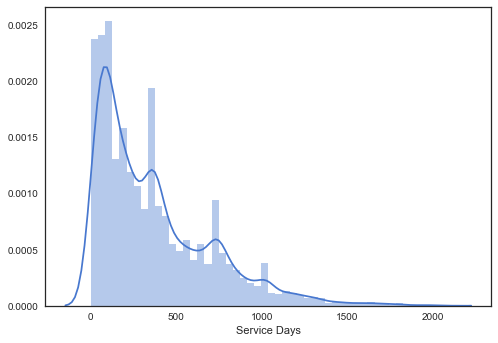

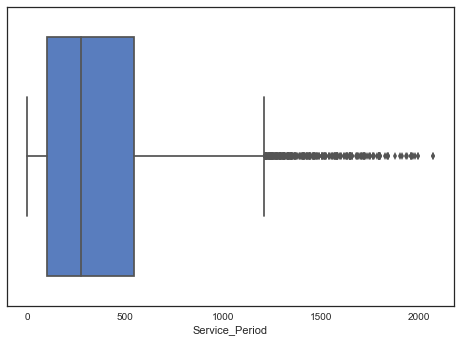

In [15]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(df1.Service_Period, axlabel="Service Days")
plt.show()
sns.boxplot(df1.Service_Period)
plt.show()

### Proportional test for Gender



<B> Null hypothesis </B> the expected female proportion of a Duke Employee a is equal to the Utility Industry population mean (35)

<p>[Avergae age of employee in Utility Industry](https://www.bls.gov/cps/cpsaat18.htm) is 26.1%</p>

A one sample t-test allows us to test whether a sample median differs significantly from a hypothesized value

In [16]:
totalcount = df1.shape[0]
noFemales = df1[df1.Gender_Name == 'Female'].shape[0]
industryRatio = 0.261
FemaleDukeRatio = noFemales/totalcount

print(' Total Count {0:0.1f}\n No of female {1:0.0f}\n Duke Female ratio {3:0.3f} \n Utility Industry ratio {2:0.3f}'.format(totalcount,noFemales,industryRatio,FemaleDukeRatio))

 Total Count 16321.0
 No of female 4119
 Duke Female ratio 0.252 
 Utility Industry ratio 0.261


In [36]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(noFemales, totalcount, industryRatio)
print('test statistic : {0:0.3f} and Pval : {1:0.3f} '.format(stat, pval ))

test statistic : -2.537 and Pval : 0.011 


<B>With 95% confidence we have enough evidence (Pval < 0.05) to reject Null Hypothesis that there female proportions are the same in the two population</B>

### Age and length of service has no correlation

In [17]:
(df1[['Age', 'Service_Period']]).corr()

,Age,Service_Period
Age,1.000000,0.114022
Service_Period,0.114022,1.000000


In [180]:
from scipy import stats

stats.ttest_1samp(df1.Age,35)

Ttest_1sampResult(statistic=24.22201537163388, pvalue=2.2891022815946972e-127)

In [40]:
# df1.head()
#df1[df1.Service_Period>1500].head()

In [38]:
df4 = df1.isnull().sum()

In [61]:
df4[df1.isnull().sum()>0]

Home_Address_State_Name                 19
Home_Address_State_Code                 19
Home_Address_Postal_Code                16
Home_Address_City                       18
Primary_Ethnic_Group_Code                3
Primary_Ethnic_Group_Name                3
Military_Status_Code                  6456
Military_Status_Name                  6456
Disabled_Indicator                    9251
Disabled_Veteran_Indicator           10420
Latest_Military_Discharge_Date       16321
Disabled_Status_Code                 10246
Disabled_Status_Name                 10246
Disabled_Disclosure_Date             10246
Effective_End_Date                    1390
Manager_Level_Name                    1762
Labor_Union_Name                     12059
EEO_Job_Group_Code                       1
Job_Function_Code                     2578
Chg_Effective_Sequence                4476
Chg_Source_Action_Code                4476
Chg_Source_Action_Reason_Code         4476
Chg_Action_Short_Name                 4476
Chg_Action_

In [60]:
null_List = df4[df1.isnull().sum()>0].index.tolist()

In [51]:
l = df5.index.tolist()

In [54]:
l

['Home_Address_State_Name',
 'Home_Address_State_Code',
 'Home_Address_Postal_Code',
 'Home_Address_City',
 'Primary_Ethnic_Group_Code',
 'Primary_Ethnic_Group_Name',
 'Military_Status_Code',
 'Military_Status_Name',
 'Disabled_Indicator',
 'Disabled_Veteran_Indicator',
 'Latest_Military_Discharge_Date',
 'Disabled_Status_Code',
 'Disabled_Status_Name',
 'Disabled_Disclosure_Date',
 'Effective_End_Date',
 'Manager_Level_Name',
 'Labor_Union_Name',
 'EEO_Job_Group_Code',
 'Job_Function_Code',
 'Chg_Effective_Sequence',
 'Chg_Source_Action_Code',
 'Chg_Source_Action_Reason_Code',
 'Chg_Action_Short_Name',
 'Chg_Action_Reason_Short_Name',
 'Chg_Activity_Group_Name',
 'Chg_Activity_Name',
 'Chg_Prior_Worker_Active_Indicator',
 'Chg_Worker_Active_Indicator',
 'Chg_Prior_JobCode_Id',
 'Chg_JobCode_Id',
 'Chg_JobTitle',
 'Chg_Source_Department_Id',
 'Chg_EEO1_Code',
 'Chg_EEO1_Name',
 'Chg_EEO_JobGroup_Code',
 'Chg_Job_Function_Code']

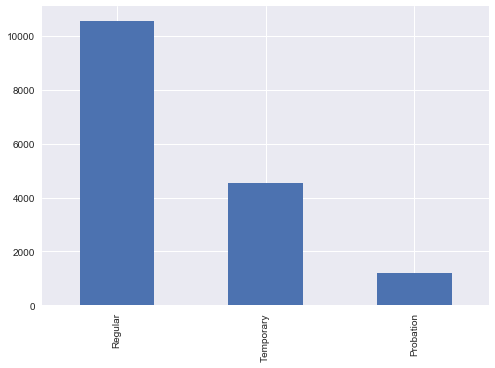

In [100]:
pd.value_counts(df2.Regular_Temporary_Name).plot.bar()
plt.show()

### Ethnic distribution

In [8]:
df1.Primary_Ethnic_Group_Name.unique()

array(['White', 'Asian', 'Not Specified', 'Black/African American',
       'American Indian/Alaska Native', 'Hispanic/Latino',
       'Native Hawaiian/Oth Pac Island', nan], dtype=object)

In [9]:
print(100*df1[df1.Primary_Ethnic_Group_Name =='White'].shape[0]/df1.shape[0], '% white')
print(100*df1[df1.Primary_Ethnic_Group_Name =='Black/African American'].shape[0]/df1.shape[0],'% Black/African American')
print(100*df1[df1.Primary_Ethnic_Group_Name =='Hispanic/Latino'].shape[0]/df1.shape[0],'% Hispanic/Latino')

77.72195331168433 % white
14.159671588750689 % Black/African American
4.558544206850071 % Hispanic/Latino


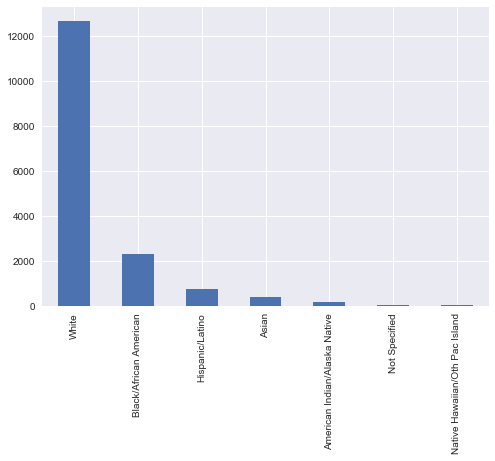

In [14]:
pd.value_counts(df1.Primary_Ethnic_Group_Name).plot.bar()
plt.show()

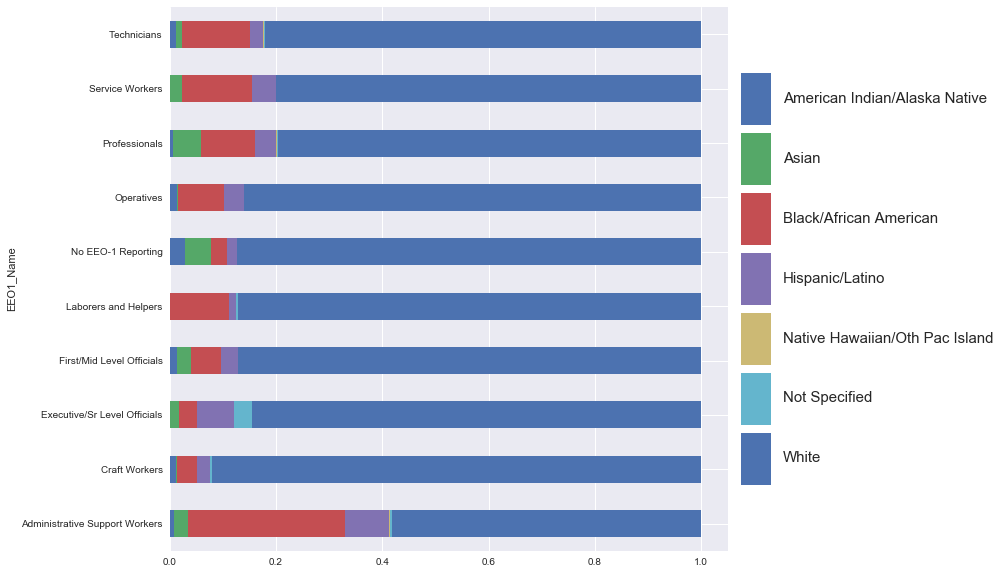

In [14]:
# the cross tab operator provides an easy way to get these numbers
ethnicity = pd.crosstab(df1['EEO1_Name'],df1['Primary_Ethnic_Group_Name'] )
ethnicity_dis = ethnicity.div(ethnicity.sum(1).astype(float),
                             axis=0) # normalize the value

# print survival_rate
ethnicity_dis.plot(kind='barh',stacked=True, figsize=(10, 10) )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handleheight=5, fontsize=15)
plt.show()


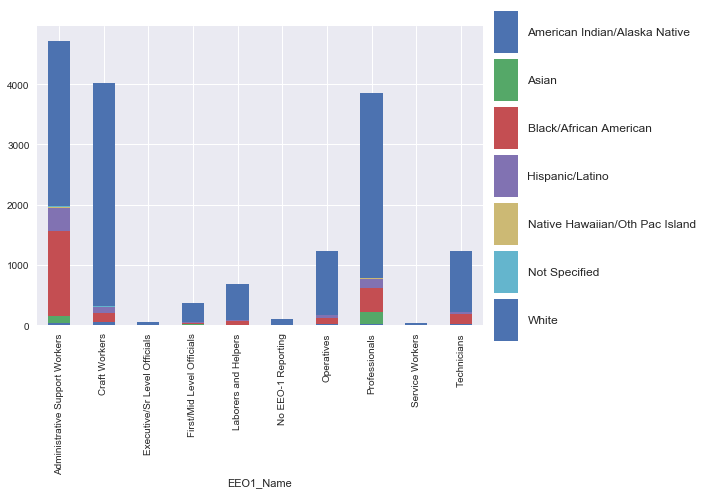

In [79]:
ethnicity = pd.crosstab(df1['EEO1_Name'],df1['Primary_Ethnic_Group_Name'] )
ethnicity.plot(kind='bar',stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handleheight=5, fontsize=12)
plt.show()

### employees ethinicity

### Chg_EEO1_Code

In [289]:
df1.Chg_EEO1_Code.unique()

array([nan, '2', '5', '3', '6', 'B', '7', 'N', 'A', '8', '9'], dtype=object)

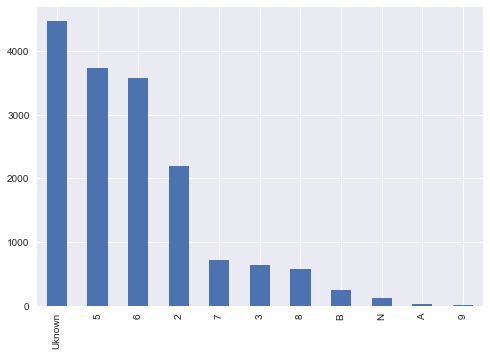

In [287]:
y = df1['Chg_EEO1_Code'].fillna("Uknown", inplace=False)
pd.value_counts(y).plot.bar()
plt.show()

#### Chg_Prior_Worker_Active_Indicator

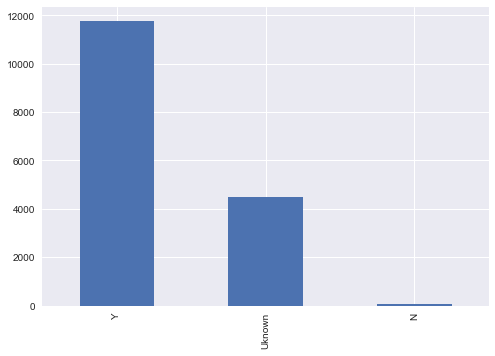

In [283]:
y = df1['Chg_Prior_Worker_Active_Indicator'].fillna("Uknown", inplace=False)
pd.value_counts(y).plot.bar()
plt.show()

### No known Chg_Effective_Start_Date

In [265]:
df1.Chg_Effective_Start_Date.isnull().sum()

4476

#### Source_Salary_Plan

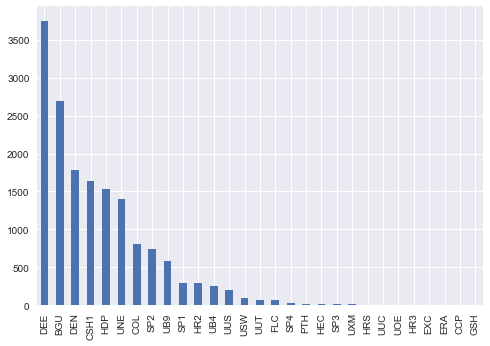

In [247]:
pd.value_counts(df1.Source_Salary_Plan).plot.bar()
plt.show()

### Salary grade on which 100 or more employees are hired 

In [240]:
x = pd.value_counts(df1.Source_Salary_Grade)>100
salarGrade100 = pd.value_counts(df1.Source_Salary_Grade)[x]
salarGrade100.sum()

13682

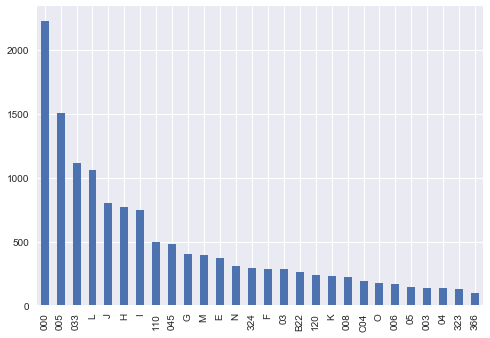

In [245]:
salarGrade100.plot.bar()
plt.show()

### Manager_Level

In [208]:
pd.value_counts(df1.Manager_Level_Name)

Individual Contributor    14098
nan                        1762
Manager                     206
Supervisor                  196
Director                     44
Vice President                7
General Manager               4
Senior Vice President         3
Group Executive               1
Name: Manager_Level_Name, dtype: int64

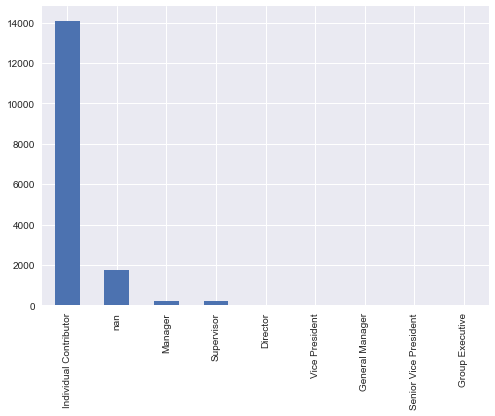

In [206]:
pd.value_counts(df1.Manager_Level_Name).plot.bar()
plt.show()

### FLSA_Classification

In [18]:
df1.FLSA_Classification_Name.unique()

array(['Administrative', 'Nonexempt', 'Professional', 'Computer Employee',
       'Executive', 'No FLSA Required'], dtype=object)

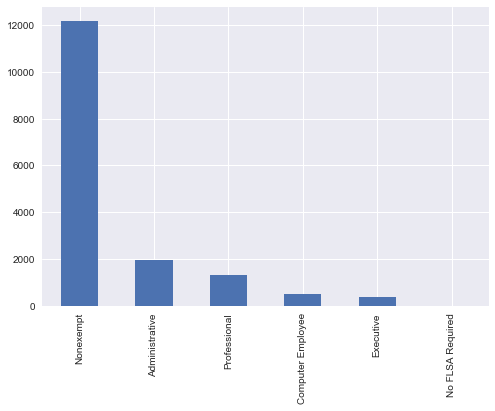

In [19]:
pd.value_counts(df1.FLSA_Classification_Name).plot.bar()
plt.show()

### Worker Classification

In [20]:
df1.Worker_Classification_Name.unique()

array(['Employee', 'Fixed Term', 'Classicore', 'Virtual',
       'CW-StaffAugment/SupplementLabr'], dtype=object)

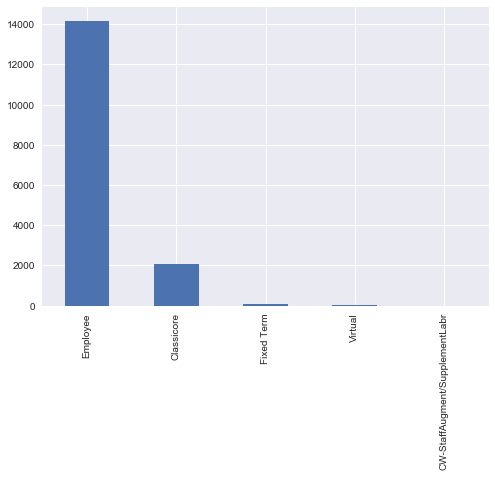

In [21]:
pd.value_counts(df1.Worker_Classification_Name).plot.bar()
plt.show()

### Disabilities - only 1.2% employees have known disabilities

In [23]:
100*df1[df1.Disabled_Indicator == 'Y'].shape[0]/df1.shape[0]

1.23154218491514

In [24]:
df1['Disabled_Indicator'].fillna("Uknown", inplace=True)

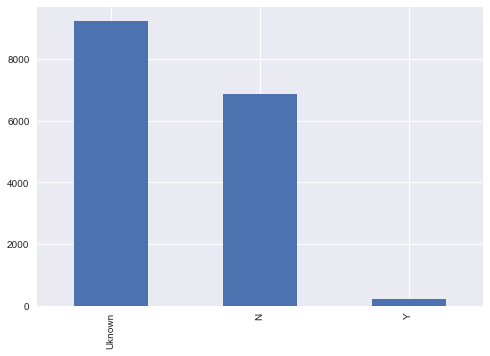

In [25]:
pd.value_counts(df1.Disabled_Indicator).plot.bar()
plt.show()

### Gender

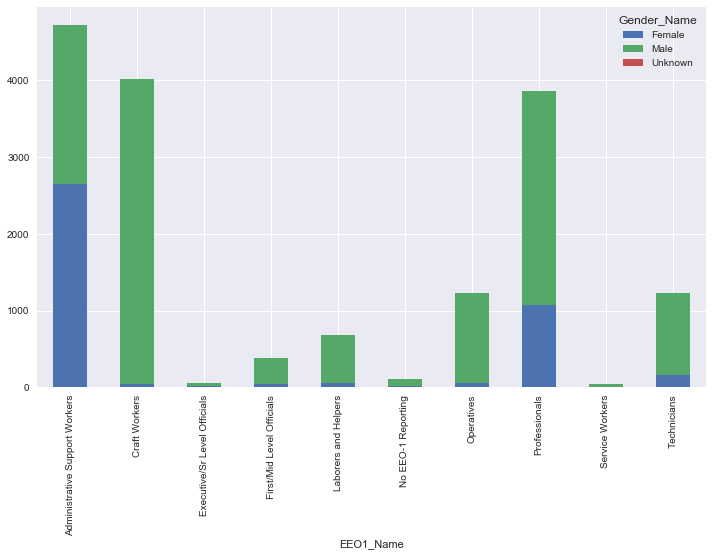

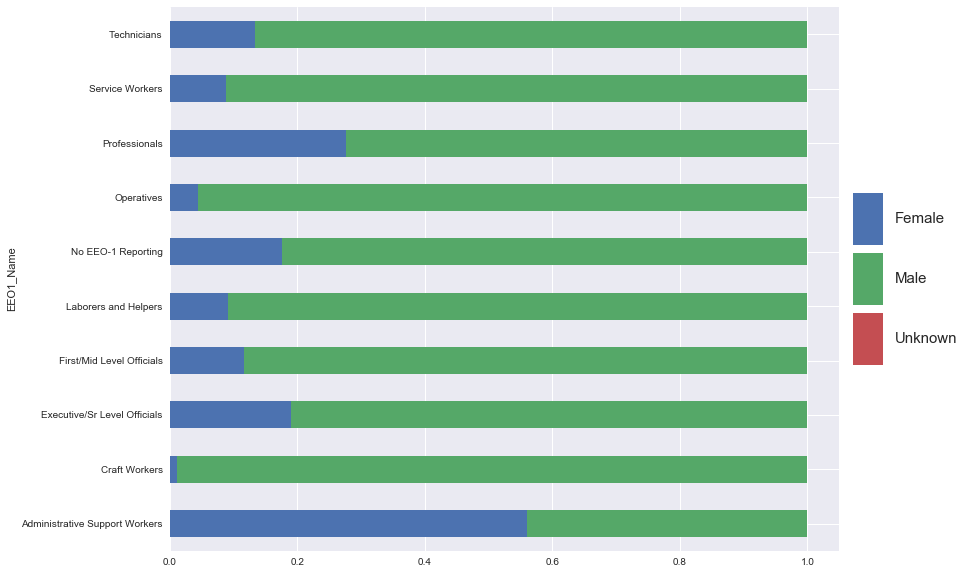

In [91]:
# the cross tab operator provides an easy way to get these numbers
gender = pd.crosstab(df1['EEO1_Name'],df1['Gender_Name'] )
gender_dis = gender.div(gender.sum(1).astype(float), axis=0) # normalize the value

gender.plot(kind='bar', stacked=True, figsize=(12, 7))

gender_dis.plot(kind='barh',stacked=True, figsize=(12, 10) )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handleheight=5, fontsize=15)
plt.show()

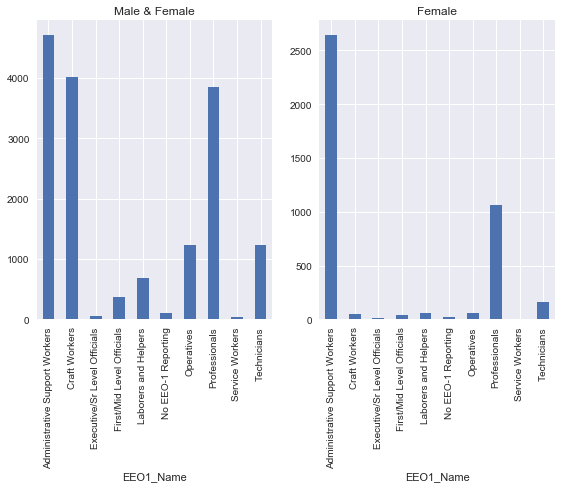

In [29]:
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2, 0)
plt.subplot(gs[0,0])
plt.title('Male & Female')
df1.groupby(['EEO1_Name']).count().Gender_Name.plot.bar()
# plt.figure(2)
plt.subplot(gs[0,1])
plt.title('Female')
df1[df1.Gender_Name == 'Female'].groupby(['EEO1_Name']).count().Gender_Name.plot.bar()

plt.show()

### 56% of the Administrative Support Workers are female

In [30]:
100*df1[(df1.Gender_Name == 'Female') & (df1.EEO1_Name =='Administrative Support Workers')].shape[0]/df1[df1.EEO1_Name =='Administrative Support Workers'].shape[0]

56.077933079203724

### 27.6% of the Professionals Workers are female

In [31]:
100*df1[(df1.Gender_Name == 'Female') & (df1.EEO1_Name =='Professionals')].shape[0]/df1[df1.EEO1_Name =='Professionals'].shape[0]

27.616580310880828

### Only 1 % of the Craft Workers are female

In [33]:
100*df1[(df1.Gender_Name == 'Female') & (df1.EEO1_Name =='Craft Workers')].shape[0]/df1[df1.EEO1_Name =='Craft Workers'].shape[0]

1.1706102117061021

In [34]:
df1['EEO1_Name'].unique()

array(['Professionals', 'Administrative Support Workers', 'Craft Workers',
       'Technicians', 'Operatives', 'First/Mid Level Officials',
       'Executive/Sr Level Officials', 'Service Workers',
       'Laborers and Helpers', 'No EEO-1 Reporting'], dtype=object)

In [172]:
# sns.barplot(data=df1, x='EEO1_Name', y = 'Gender_Name')


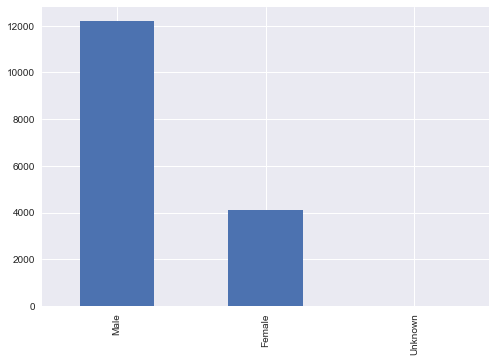

In [35]:
pd.value_counts(df1.Gender_Name).plot.bar()
plt.show()

### Employee Sates - 93% of the employees are from Indiana, North Carolina, South Carolina, Florida, Kentucky, Ohio

In [95]:
df1[df1['Home_Address_State_Name'].isin(
    ['Indiana', 'North Carolina', 'South Carolina', 'Florida', 'Kentucky', 'Ohio'])].shape[0]/df1.shape[0]

0.93119294160897

In [78]:
states = ['Indiana', 'North Carolina', 'South Carolina', 'Kentucky', 'Ohio', 'Florida', 'Texas','Illinois']
df_states = df1[df1['Home_Address_State_Name'].isin(states)]

In [81]:
100*df_states.shape[0]/df1.shape[0]

94.54690276331107

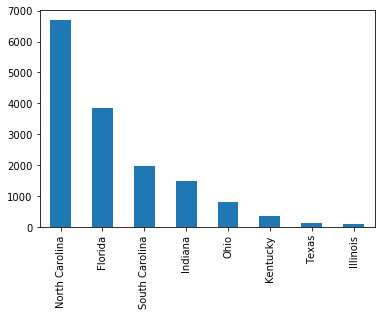

In [67]:
pd.value_counts(df_states.Home_Address_State_Name).plot.bar()
plt.show()

In [71]:
x= pd.value_counts(df_states.Home_Address_State_Name)

In [75]:
x

North Carolina    6683
Florida           3838
South Carolina    1994
Indiana           1502
Ohio               827
Kentucky           354
Texas              138
Illinois            95
Name: Home_Address_State_Name, dtype: int64

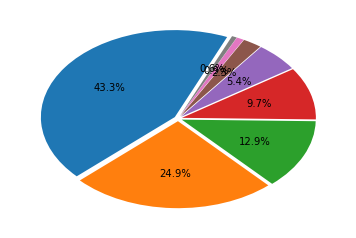

In [77]:
from pylab import *

# x = list(df_states.Home_Address_State_Name)
explode = [0.03]*len(x)
pie(list(x), explode=explode,  autopct='%1.1f%%', startangle=67)

show()

In [58]:
df1['Home_Address_State_Name'] in states

['Indiana',
 'North Carolina',
 'Kentucky',
 'Ohio',
 'Florida',
 'Texas',
 'Illinois',
 'South Carolina']

### Labor Union jobs makes up 26% of the new hire

In [43]:
100*df1[df1.Labor_Union_Name.notnull()].shape[0]/df1.shape[0]

26.11359598063844

In [46]:
df1['Labor_Union_Name'].fillna("Non Union", inplace=True)

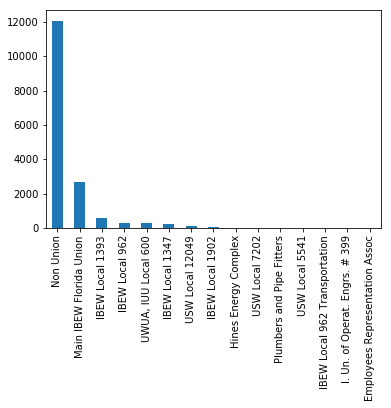

In [47]:
pd.value_counts(df1.Labor_Union_Name).plot.bar()
plt.show()

### Manager Level Name has 86.3% individual contributor and 10.7% unknown

In [22]:
100*df1[df1.Manager_Level_Name == 'Individual Contributor'].shape[0]/df1.shape[0]

86.37951105937137

In [25]:
100*df1[df1.Manager_Level_Name == 'nan'].shape[0]/df1.shape[0]

10.79590711353471

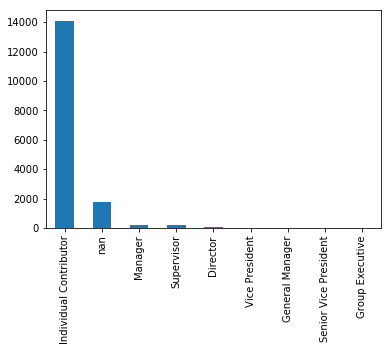

In [20]:
import matplotlib.pyplot as plt
pd.value_counts(df1.Manager_Level_Name).plot.bar()
plt.show()

In [4]:
# Diplay the entire columns 
pd.set_option('display.max_columns', None)

### 1390 employees(8.5% of the hire) are in there initial hire postion

In [81]:
df1[df1.Effective_End_Date.isnull()].shape, 100*df1[df1.Effective_End_Date.isnull()].shape[0]/df1.shape[0]

((1390, 60), 8.516635010109674)

### Rehired employees 

In [37]:
df1['Chg_Worker_Active_Indicator'].fillna("Unkown", inplace=True)

In [49]:
Duplicate = df1[df1.duplicated(subset=df1[['Primary_Full_Name','Birth_Date']], keep='first')]

In [9]:
# pd.value_counts(Duplicate.Source_Worker_Id)

In [39]:
Duplicate1 = df1[df1.duplicated(subset=df1[['Source_Worker_Id']], keep='first')]

In [40]:
Duplicate.shape, Duplicate1.shape

((2851, 62), (2849, 62))

In [40]:
Termination= df1.set_index('Chg_Effective_Start_Date')
Termination.shape

(16321, 59)

In [41]:
Termination = Termination.loc[pd.notnull(Termination.index)]
Termination.shape

(11845, 59)

In [27]:
# Termination

In [43]:
Duplicate_ChangeActivity = pd.crosstab(Duplicate.EEO1_Name, Duplicate.Chg_Worker_Active_Indicator)

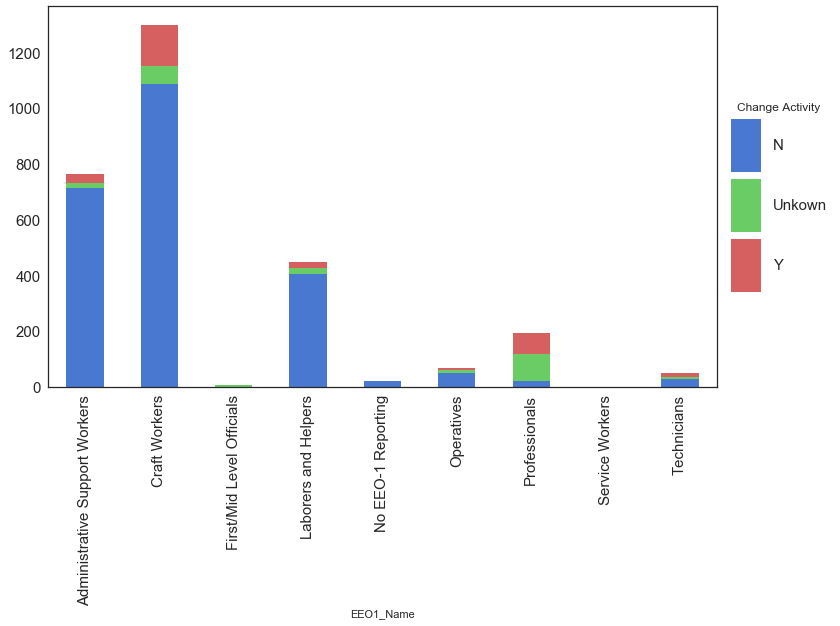

In [47]:
Duplicate_ChangeActivity.plot(kind='bar', stacked=True, figsize=(12, 7), fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handleheight=5, title = 'Change Activity', fontsize=15)
plt.show()

In [44]:
NonDuplicate = df1.drop_duplicates(['Source_Worker_Id'], keep='last')

In [45]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
df4=df2.Source_Worker_Id.resample('W')

In [64]:
df4.head()

C:\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called head(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


Effective_Start_Date
2012-01-08    294039.300000
2012-01-15    300661.042857
2012-01-22    297045.666667
2012-01-29    324622.000000
2012-02-05    317479.714286
Freq: W-SUN, Name: Source_Worker_Id, dtype: float64

In [74]:
Hire_Weekly.sum()

4538

In [71]:
Hire_Weekly = df2.Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Hire Weekly")
show(ts)

In [47]:
df1.Chg_Effective_Start_Date.isnull().count(), df1.Chg_Worker_Active_Indicator.isnull().count()

(16321, 16321)

In [65]:
df1.EEO_Job_Group_Code.unique()

array(['23', '52', '24', '22', '62', '5A', '31', '51', '71', '32', 'B1',
       '61', 'B2', '21', 'A1', '91', '3', '2D', '81', '6', '2C', '1C',
       'A2', '2E', '7', 'XX', '8', '2B', '5B', nan, '2A', '92', '1B', '33',
       '25'], dtype=object)

In [48]:
Hire_City = pd.value_counts(df1.Home_Address_City)
Hire_City[Hire_City>200]

Charlotte        1795
Cincinnati        413
Raleigh           404
Dunnellon         300
Crystal River     280
Name: Home_Address_City, dtype: int64

In [49]:
(df2.Department_Name).str.contains('Call').sum()

503

In [12]:
Hire_Weekly = df2[df2.Regular_Temporary_Name=='Regular'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Regular hire Weekly")
show(ts)

C:\Continuum\Anaconda3\lib\site-packages\bokeh\core\json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [13]:
Hire_Weekly = df2[df2.Regular_Temporary_Name=='Temporary'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Temporary hire Weekly")
show(ts)

In [14]:
Hire_Weekly = df2[df2.Regular_Temporary_Name=='Probation'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Probation hire Weekly")
show(ts)

In [15]:
Hire_Weekly = df2[((df2.Department_Name).str.contains('Call'))].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Call hire Weekly")
show(ts)

output_notebook()

Loading BokehJS ...

In [54]:
# df2[~((df2.Department_Name).str.contains('Call'))].Source_Worker_Id
df2[df2.Regular_Temporary_Name=='Probation'].Source_Worker_Id.resample('M').count().sum()

1210

In [55]:
# (~(df2.Regular_Temporary_Name=='Regular')).sum() + (df2.Regular_Temporary_Name=='Regular').sum()
df2[((df2.Department_Name).str.contains('Call'))].Source_Worker_Id.resample('W').count().sum()

503

In [32]:
ts =Termination[Termination.Chg_Worker_Active_Indicator=='Y']

In [34]:
v = ts.Source_Worker_Id.resample('W').count()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [44]:
Termination_Weekly = Termination[Termination.Chg_Worker_Active_Indicator=='Y'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Termination_Weekly, plot_width=960, plot_height=550,  title="Chg_Worker_Active_Indicator - Y Weekly")
show(ts)

In [43]:
Termination_Weekly = Termination[Termination.Chg_Worker_Active_Indicator=='N'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Termination_Weekly, plot_width=960, plot_height=550,  title="Termination/Chg_Worker_Active_Indicator - N Weekly")
show(ts)

In [58]:
Departure = df1.loc[pd.notnull(df1.Effective_End_Date)]

Departure = df1.loc[pd.notnull(df1.Effective_End_Date)]
Departure_City = pd.value_counts(Departure.Home_Address_City)
Departure_City[Departure_City>200]

Charlotte        1551
Raleigh           364
Cincinnati        355
Dunnellon         290
Crystal River     270
Name: Home_Address_City, dtype: int64

In [59]:
NonDuplicate = NonDuplicate.set_index('Effective_End_Date')

In [60]:
NonDuplicate = NonDuplicate.loc[pd.notnull(NonDuplicate.index)]

In [61]:
NonDuplicate.shape

(12156, 61)

NonDuplicate_Weekly = NonDuplicate.Source_Worker_Id.resample('M').count()
ts = TimeSeries(NonDuplicate_Weekly, plot_width=960, plot_height=600)
show(ts)

df3[df3.index.notnull()].shape

### 132 employees are re-hired

In [45]:
Duplicate.Primary_Full_Name.unique().shape[0]

1132

In [48]:
Duplicate.shape

(2851, 60)

### 17.5 % of data is rehire

In [49]:
100*Duplicate.shape[0]/df1.shape[0]

17.468292384045096

In [50]:
Duplicate_workID = Duplicate.groupby(['Source_Worker_Id']).count()

In [51]:
Duplicate_workID[Duplicate_workID['Primary_Full_Name']==15].index

Int64Index([248556, 359332, 362456], dtype='int64', name='Source_Worker_Id')

#### 61.7 % of the duplicates are unions and 37.3% non unions

In [120]:
Duplicate.Chg_Effective_Start_Date.isnull().sum()

223

In [324]:
100*Duplicate.Labor_Union_Name.notnull().sum()/Duplicate.shape[0]

61.697649947386878

In [352]:
df1['Regular_Temporary_Name'].unique()

array(['Regular', 'Probation', 'Temporary'], dtype=object)

In [57]:
z=Duplicate[Duplicate['Regular_Temporary_Name'] == 'Regular']                       

In [65]:
DuplicateReglar = Duplicate[Duplicate['Regular_Temporary_Name'] == 'Regular']    
DuplicateReglar.shape[0]/Duplicate.shape[0]

0.10101718695194668

In [59]:
DuplicateHourly=z[z.Employee_Type_Name == 'Hourly'].Primary_Full_Name.unique()

In [60]:
DuplicateHourly.shape

(109,)

In [48]:
DuplicateReglar.shape

(287,)

In [104]:
x = list(Duplicate['Labor_Union_Name'].unique())

In [105]:
x

['UWUA, IUU Local 600',
 nan,
 'Main IBEW Florida Union',
 'IBEW Local 1393',
 'IBEW Local 1902',
 'IBEW Local 962',
 'Employees Representation Assoc',
 'IBEW Local 1347',
 'Hines Energy Complex']

In [11]:
duplicate_bar = Duplicate.groupby([Duplicate['Primary_Full_Name']]).count()

In [122]:
Duplicate['Count'] = 0

C:\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
y = Duplicate[['Primary_Full_Name','Birth_Date','Count']].groupby(['Primary_Full_Name','Birth_Date']).count()  

In [126]:
y[y.Count>14]

,,Count
Primary_Full_Name,Birth_Date,
"Davis,Noah A",1970-12-16,15
"Parrott,Robert Thomas",1962-07-22,15
"Young,Derek J",1980-12-27,15


In [28]:
parse_dates = [4, 17, 20, 22, 23, 41]
l = [4, 17, 20, 22, 23, 41,50]

In [29]:
d = {value: key for (key, value) in enumerate(df1.columns)}

In [27]:
(df1['Chg_Worker_Active_Indicator'] == 'N').sum()

5549

In [41]:

#df1.iloc[:,l][df1.Primary_Full_Name == 'Davis,Noah A'].sort_values(by=['Chg_Effective_Start_Date'], ascending=True)

In [66]:
# y[y.Count>10]
pd.set_option('display.max_columns', None)

In [42]:
#df2.head()

In [15]:
Hire_Weekly = df2.Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=600, title='Weekly Hire')
output_file('Weekly_Hire.html')
show(ts)

C:\Continuum\Anaconda3\lib\site-packages\bokeh\core\json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [31]:
Hire_Weekly = df2[df2.Regular_Temporary_Name=='Regular'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Regular hire Weekly")
show(ts)

In [32]:
Hire_Weekly = df2[df2.Regular_Temporary_Name=='Temporary'].Source_Worker_Id.resample('W').count()
ts = TimeSeries(Hire_Weekly, plot_width=960, plot_height=550, title="Temporary hire Weekly")
show(ts)

In [22]:
type(Termination.index)

pandas.core.indexes.base.Index

In [38]:
dfEnd.head()

,Tabname,Source_Worker_Id,Primary_Full_Name,Gender_Name,Birth_Date,Home_Address_State_Name,Home_Address_State_Code,Home_Address_Postal_Code,Home_Address_City,Primary_Ethnic_Group_Code,...,Chg_Worker_Active_Indicator,Chg_Prior_JobCode_Id,Chg_JobCode_Id,Chg_JobTitle,Chg_Source_Department_Id,Chg_EEO1_Code,Chg_EEO1_Name,Chg_EEO_JobGroup_Code,Chg_Job_Function_Code,Rnk
Effective_End_Date,,,,,,,,,,,,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-25,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
Termination_Weekly = Termination.Source_Worker_Id.resample('W').count()
ts = TimeSeries(Termination_Weekly, plot_width=960, plot_height=600, title='Weekly_departure')
output_file('Weekly_departure.html')
show(ts)

In [133]:
# df2.dtypes

In [ ]:
df1['Age'] = datetime.now().year - df1['Birth_Date'].dt.year

df1['Age_at_Hire'] = df1['Effective_Start_Date'].dt.year - df1['Birth_Date'].dt.year


df1['Chg_Effective_Start_Date'].fillna(datetime.today(), inplace=True)